# Ciencia de Datos. TP1: Análisis Básicos

Axel Maddonni, LU 200/14 <br>
Federico Patane, LU 683/10<br>


*Septiembre 2017*

***

## Introducción

En el presente trabajo se estudiarán los datos de entrenamientos provenientes de 12 corredores de 100 metros llanos. Se tomaron tiempos de duración para distintas carreras de cada corredor,  en distintas condiciones climáticas, siendo éstas soleado, nublado y lluvioso. Trataremos de extraer información de los datos recolectados, utilizando gráficos para la visualización de los mismos y tests de hipótesis para afirmar o rechazar diferentes escenarios que serán planteados en el trabajo.

## Limpieza y Visualización de los datos

Para poder realizar experimentos y calcular métricas sobre un set de datos, debemos asegurarnos utilizando alguna política de decisión, que los datos utilizados sean coherentes, es decir que tengan sentido en la naturaleza del dominio del problema que estamos tratando.  

En primer instancia, graficaremos los datos con el set completo, es decir, sin quitar los datos incoherentes.

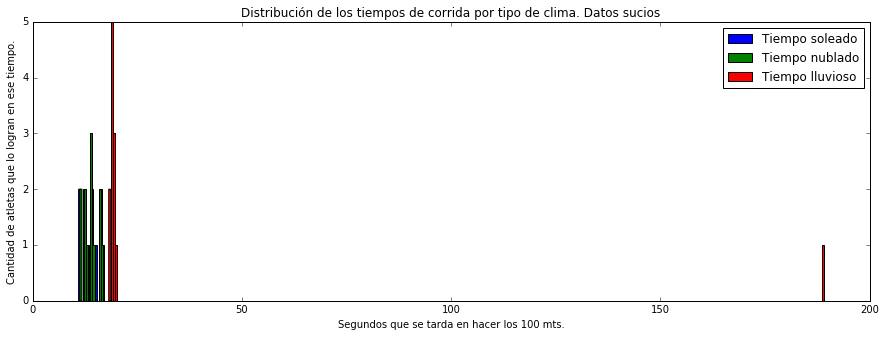

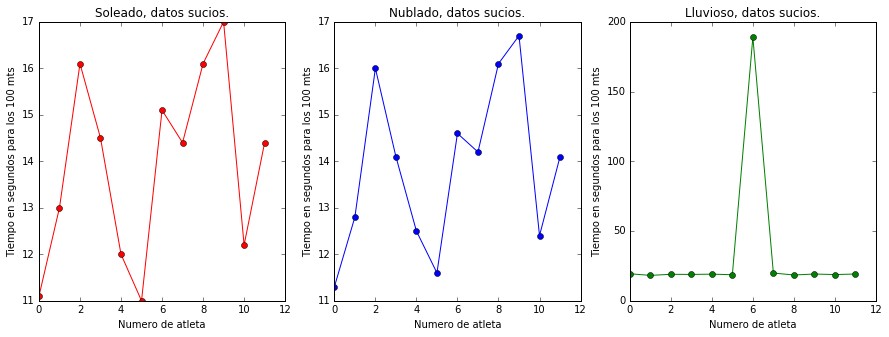

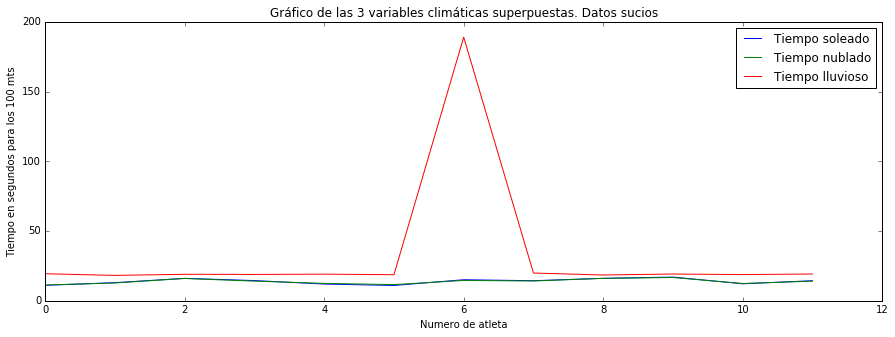

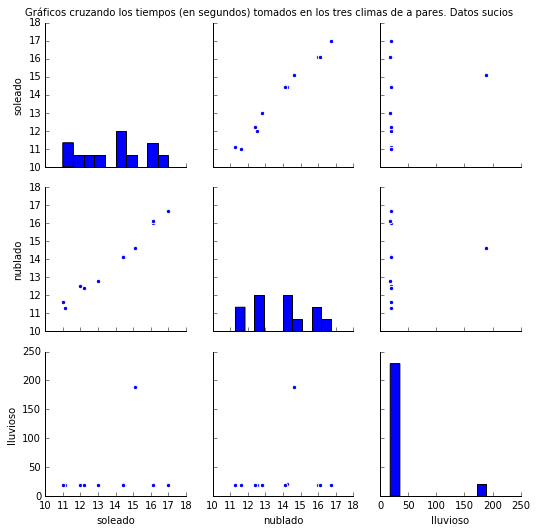

In [317]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as sp
import operator

def plot(data, data_type):
   d1 = data[:,0]
   d2 = data[:,1]
   d3 = data[:,2]
   binwidth = 0.5

   plt.figure(figsize=(15, 5))
   plt.hist(d1,bins=np.arange(min(d1), max(d1) + binwidth, binwidth), label="Tiempo soleado")
   plt.hist(d2,bins=np.arange(min(d2), max(d2) + binwidth, binwidth), label="Tiempo nublado")
   plt.hist(d3,bins=np.arange(min(d3), max(d3) + binwidth, binwidth), label="Tiempo lluvioso")
   plt.legend(loc='upper right')
   plt.xlabel("Segundos que se tarda en hacer los 100 mts.")
   plt.ylabel("Cantidad de atletas que lo logran en ese tiempo.")
   plt.title(("Distribución de los tiempos de corrida por tipo de clima. Datos " + data_type).decode('utf-8'))
   plt.show()

   plt.figure(figsize=(15, 5))
   plt.title(("Gráfico de las 3 variables climáticas por separado. Datos " + data_type).decode('utf-8'))
   plt.subplot(1,3,1)
   plt.plot(d1, "r-" , marker='o')
   plt.title("Soleado, datos " + data_type+".")
   plt.xlabel("Numero de atleta")
   plt.ylabel("Tiempo en segundos para los 100 mts")
   plt.subplot(1,3,2)
   plt.plot(d2, "b-", marker='o')
   plt.title("Nublado, datos " + data_type+".")
   plt.xlabel("Numero de atleta")
   plt.ylabel("Tiempo en segundos para los 100 mts")
   plt.subplot(1,3,3)
   plt.plot(d3, "g-", marker='o')
   plt.title("Lluvioso, datos " + data_type+".")
   plt.xlabel("Numero de atleta")
   plt.ylabel("Tiempo en segundos para los 100 mts")
   plt.show()

   plt.figure(figsize=(15, 5))
   plt.plot(d1, label="Tiempo soleado")
   plt.plot(d2, label="Tiempo nublado")
   plt.plot(d3, label="Tiempo lluvioso")
   plt.xlabel("Numero de atleta")
   plt.ylabel("Tiempo en segundos para los 100 mts")
   plt.legend(loc='upper right')
   plt.title(("Gráfico de las 3 variables climáticas superpuestas. Datos " + data_type).decode('utf-8'))
   plt.show()
 
   data_frame = pd.DataFrame(data)
   data_frame.columns = ["soleado" , "nublado" , "lluvioso"]
   sns_plot = sns.pairplot(data_frame)
   plt.subplots_adjust(top=0.95)
   sns_plot.fig.suptitle(("Gráficos cruzando los tiempos (en segundos) tomados en los tres climas de a pares. Datos " + data_type).decode('utf-8'))
   plt.show()

data = np.loadtxt('tiempos.txt')
plot(data , "sucios")


Se puede observar la existencia de un valor dentro de los tiempos tomados con lluvia muy diferente del resto de los valores, sin embargo, estos casos no siempre pueden observarse a simple vista. Para detectar outliers, medimos la distancia entre los tiempos y la media para cada clima, contra su desvío estándar multiplicado por una constante. Realizando este cálculo, se procede a extraer de la muestra los valores tomados para el corredor al que corresponde el outlier, producido por alguna razón que desconocemos.

Una vez extraído este valor pasamos a graficar nuevamente los datos, para obtener imágenes más claras y poder visualizar cómo se relacionan los datos de la muestra.


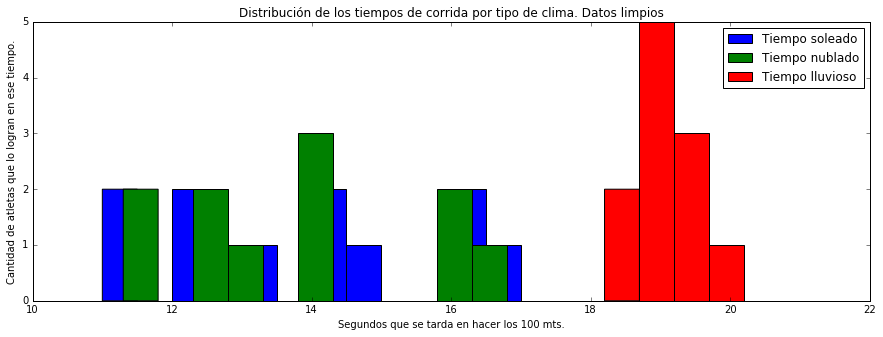

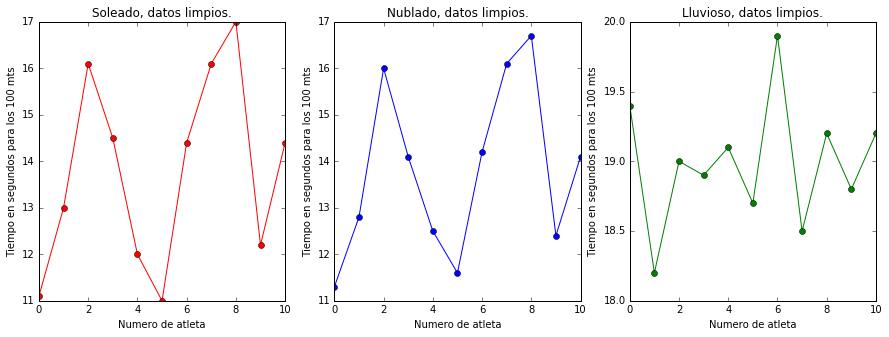

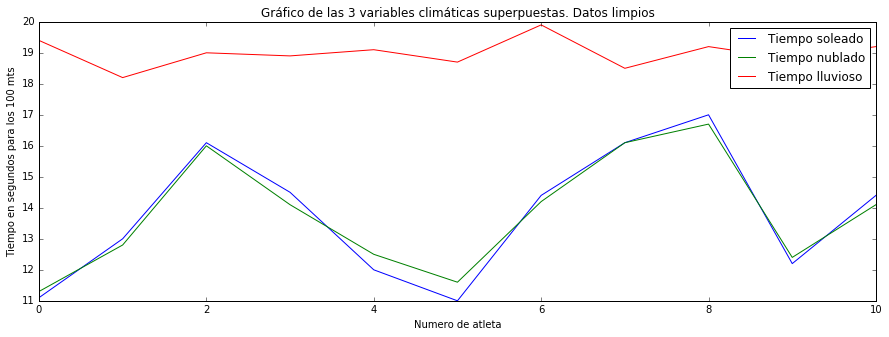

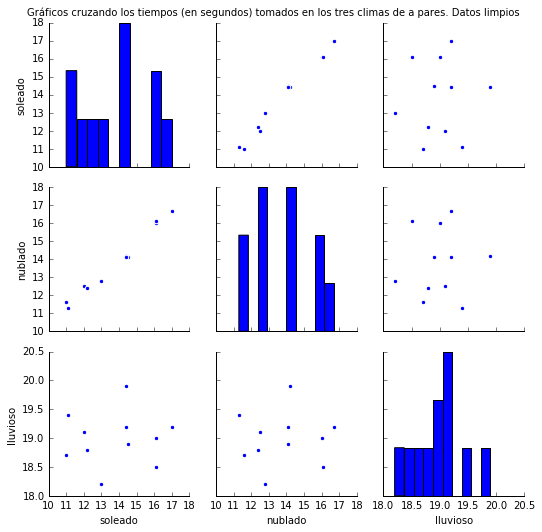

In [133]:
def cleanData(data):
   means = []
   stds = []
   for c in xrange(0, data.shape[1]):
      means.append(np.mean(data[:][c]))
      stds.append(np.std(data[:][c]))
   return np.array(filter(lambda r: filterDataRows(r, means, stds), data))

def filterDataRows(row, means, stds):
   for index in range(len(row)):
      if (abs(row[index] - means[index]) > 5 * stds[index]):
         return False
   return True

data = cleanData(data)
plot(data, "limpios")

Mirando los gráficos podemos observar a simple vista que los valores tomados con lluvia son mayores a los tomados en los otros climas. Además, podemos ver claramente que los valores tomados con sol y nubes no presentan grandes diferencias entre sí y presentan una correlación, es decir, cuando uno de las dos variables va tomando valores cada vez ḿas grandes, tambíen lo hace la otra.

## Tests y Conclusiones

### 1. Los atletas son mas lentos en días de lluvia que en días soleados.

Para analizar esta afirmación, utilizaremos un test de una cola. Es decir, plantearemos en la hipótesis nula que las medias de ambas muestras son iguales, e intentaremos por medio del test de una cola, poder ver que esto no es así, siendo la lluviosa la de mayor tiempo promedio en las corridas. 

Para poder utilizar los test de T-Student, necesitamos que nuestras muestras tengan una distribución Gaussiana. Si bien en los gráficos anteriores podemos ver alguna semenjanza a una gráfica de una normal, tenemos muy pocos datos como para poder asegurarlo de una manera más fuerte, por lo  que decidimos trabajar con un test no paramétrico, en este caso el test de Mann-Whitney.

Recordemos la teoría sobre los test y el p-valor. Cuando ejecutemos el test, dependiendo del pvalor resultante podremos rechazar la hipótesis nula, dando así por cierta nuestra hipótesis alternativa (que en este caso al ser un test de una cola a derecha, concluiremos que los atletas son más lentos en días de lluvia, por sobre los días soleados) o, en caso de que el pvalor no sea menor al nivel de significancia elegido, no tendremos información suficiente para decidir sobre la hipótesis. 

Como dijimos anteriormente, ejecutamos el test no paramétrico de Mann-Whitney con una cola, evaluando que la muestra de tiempos de días soleados sea menor a la de la muestra de días lluviosos. Para este test suponemos que las muestras son independientes, por lo que realizamos un shuffle antes de realizar el mismo, para sacar la variable de tiempos por atleta.

El resultado del mismo nos da un pvalor de 0.0000401937.
Al ser este número menor al nivel de significancia (0.05) entonces rechazamos la hipótesis nula y así nos quedamos con la alternativa, por lo que efectivamente podemos concluir que dadas las muestras obtenidas, los atletas son más lentos en días de lluvia.

In [187]:
soleado = data[:, 0]
nublado = data[:, 1]
lluvioso = data[:, 2]

def testMannWhitney1Cola(d1, d2):
   """
   H0 = Las muestras provienen de distribuciones de igual media
   H1 = La distribuion de d2 tiene media mayor que la distribucion d1
   Vamos a usar el test de scipy.stats.mannwhitneyu a 1 cola
   """
   rd1 = np.copy(d1)
   rd2 = np.copy(d2)
   np.random.shuffle(rd1)
   np.random.shuffle(rd2)
   f = sp.mannwhitneyu(rd1, rd2, alternative='less')
   return f[0] , f[1] 

estadistico , pvalor = testMannWhitney1Cola(soleado, lluvioso)
print 'P-valor: %.10f' % pvalor

P-valor: 0.0000401937


### 2. El cielo nublado no influye en los tiempos de los atletas.

Como vimos anteriormente en los gráficos, los valores obtenidos en clima soleado y nublado no varían mucho. Además, la media de ambas muestras es la misma, menor a la obtenida en los días lluviosos. 

Podemos graficar la relación del cociente entre los tiempos obtenidos por los atletas en clima nublado y los que obtuvieron en clima soleado, y observar que éste gira en torno al valor 1 con muy poca variación, lo que sostiene nuestra idea.

Además, calculando el ranking de tiempos por atleta en clima soleado y en clima nublado, vemos que no hay muchas diferencias en los órdenes de llegada, comparado con el ranking obtenido en clima con lluvias.

Analizando estos datos, tenemos una certeza informal de que el cielo nublado no hace variar los tiempos de los atletas, o de alguna manera en la mejor marca de ellos. Aún así esto no nos alcanza para poder afirmar la idea, por más que nos parezca razonable. No podemos realizar un test estadístico, ya que no podemos formular una hipótesis nula que afirme que "Las medias no son iguales" o similar, la cual rechazar.

A continuación, exponemos el ranking de corredores en clima soleado versus nublado y el gráfico del cociente mencionado.

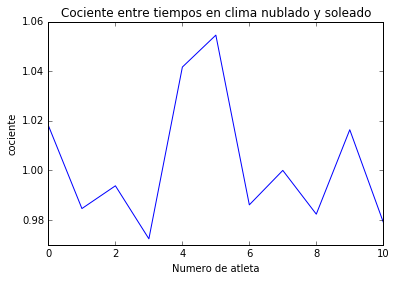

Desvío estándar del cociente entre Nublado/Soleado:  0.0255885043154

Ranking de corredores (enumerados del 1 al 11):

  Soleado    Nublado
---------  ---------
        6          1
        1          6
        5         10
       10          5
        2          2
        7          4
       11         11
        4          7
        3          3
        8          8
        9          9


In [185]:
from tabulate import tabulate

plt.plot(nublado/soleado)
plt.xlabel("Numero de atleta")
plt.ylabel("cociente")
plt.legend(loc='upper right')
plt.title("Cociente entre tiempos en clima nublado y soleado")
plt.show()

print "Desvío estándar del cociente entre Nublado/Soleado: ", np.std(nublado/soleado)
print ""

rankingSoleado = [i[0]+1 for i in sorted(enumerate(soleado), key=lambda x:x[1])]
rankingNublado = [i[0]+1 for i in sorted(enumerate(nublado), key=lambda x:x[1])]

print "Ranking de corredores (enumerados del 1 al 11):"
print ""
print tabulate(zip(rankingSoleado, rankingNublado), headers=['Soleado', 'Nublado'])



### 3. La velocidad en días de lluvia es independiente del atleta

En principio, para analizar esta idea podemos ayudarnos de los gráficos donde anteriormente mostramos los tiempos cruzados de a pares, es decir clima versus clima. En lo que respecta a nublado y soleado podemos ver una correlación bastante fuerte, esto significa, una relación entre el tiempo que un atleta hizo en nublado, con el tiempo que ese mismo atleta hizo en soleado.

Sin embargo, en los cruces con los datos tomados en clima lluvioso, no podemos ver una relación a simple vista entre los tiempos obtenidos, es decir que mirando el tiempo obtenido de un atleta en clima soleado o nublado, no podemos predecir mucho sobre los tiempos que obtuvo en clima lluvioso.

Esto nos sirve como un primer acercamiento para darnos cuenta, o de alguna manera informal, poder sospechar de una manera bastante fuerte, que la muestra de lluvia es independiente a la de las otras dos.

Una manera para poder fortalecer esta idea, será haciendo un ranking, tamando por ejemplo, día soleado versus día lluvioso. De esta manera, vemos que no se respetan en absoluto las posiciones finales de la carrera, entre un día y el otro, dándonos claramente una señal de que los datos no se comportan de igual manera. Además, como en el caso anterior, graficamos la relación del cociente entre los tiempos en clima lluvioso y soleado, donde se puede ver  que el rango de variación de los cocientes obtenidos es mucho mayor que en el gráfico anterior. El desvío estándar obtenido (aprox. 0.2) es mayor al obtenido en el caso anterior (aprox. 0,02).

Con estos datos podemos tener información fuerte como para poder sospechar que la variable de lluvia es independiente del atleta, pero aún así no tenemos información necesaria como para asegurarlo ya que no sabemos de qué manera puede influir. Al igual que en el caso anterior, no podemos formular un test para sacar conclusiones sobre independencia de estas variables, ya que este tipo de conclusiones requieren una hipótesis nula infinita, que abarque todas las posibles alternativas de dependencia.


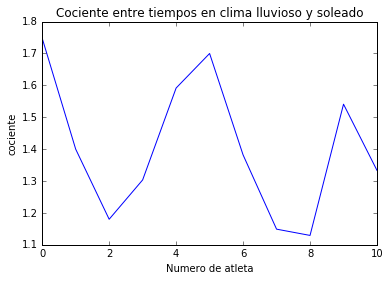

Desvío estándar del cociente entre Lluvioso/Soleado:  0.205793533674

Ranking de corredores (enumerados del 1 al 11):

  Soleado    Lluvioso
---------  ----------
        6           2
        1           8
        5           6
       10          10
        2           4
        7           3
       11           5
        4           9
        3          11
        8           1
        9           7


In [186]:
plt.plot(lluvioso/soleado)
plt.xlabel("Numero de atleta")
plt.ylabel("cociente")
plt.legend(loc='upper right')
plt.title("Cociente entre tiempos en clima lluvioso y soleado")
plt.show()

print "Desvío estándar del cociente entre Lluvioso/Soleado: ", np.std(lluvioso/soleado)
print ""

rankingLluvioso = [i[0]+1 for i in sorted(enumerate(lluvioso), key=lambda x:x[1])]

print "Ranking de corredores (enumerados del 1 al 11):"
print ""
print tabulate(zip(rankingSoleado, rankingLluvioso), headers=['Soleado', 'Lluvioso'])

### 4. El clima influye en la velocidad de los atletas

Para este caso, además de lo usado hasta el momento, y para afirmar esta idea, realizamos un test de permutaciones en el cual mantendremos el apareamiento de la muestra (es decir, los valores obtenidos por atleta). Tomando la media real de las muestras, intentaremos rechazar la siguiente hipótesis nula: "Las medias entre los tiempos obtenidos en clima soleado y lluvioso no difieren". Es decir, es un test similar al que realizamos para la primera conclusión. En este caso realizaremos un test de 2 colas, con 10000 permutaciones donde calcularemos la diferencia entre las medias de clima lluvioso y de clima soleado obtenidas en cada caso. Las permutaciones las haremos por fila, es decir, manteniendo los valores que obtuvo cada corredor, pero permutando los climas a los que corresponde cada valor, y luego contaremos cúantas de dichas permutaciones dan una diferencia mayor o igual a la real para obtener el pvalor.

Luego, compararemos el resultado obtenido con el test no-paramétrico de Wilcoxon (también de 2 colas para muestras apareadas).

Diferencia real entre las medias de tiempos de clima lluvioso y soleado: 5.19090909091


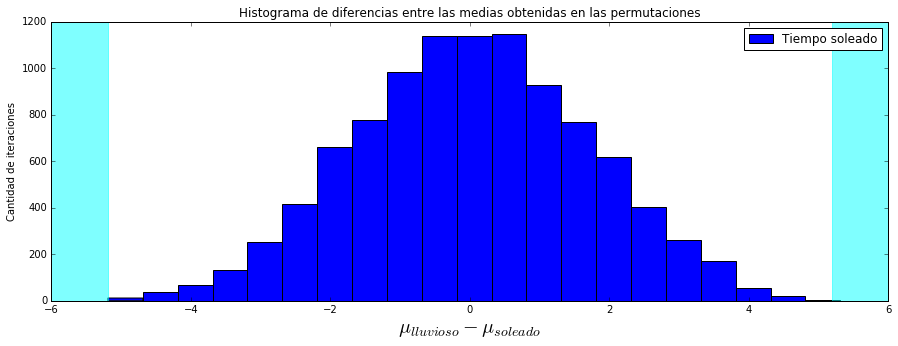

P-valor obtenido con el test de Permutaciones: 0.0006000000
P-valor obtenido con el test de Wilcoxon: 0.0033456181


In [316]:
def testWilcoxon2Colas(d1, d2):
   f = sp.wilcoxon(d1, d2)
   return f[1] 

def testPermutaciones2Colas(d1, d2):
    diffReal = d2.mean() - d1.mean()
    print "Diferencia real entre las medias de tiempos de clima lluvioso y soleado:", diffReal
    iter = 10000
    diff = np.zeros(iter)
    for x in xrange(0,iter):
       perm = np.random.randint(2, size=d1.size)
       rd1 = np.zeros(d1.size)
       rd2 = np.zeros(d1.size)
       for i in xrange(0, d1.size):
          if (perm[i]):
             rd1[i] = d2[i]
             rd2[i] = d1[i]
          else:
             rd1[i] = d1[i]
             rd2[i] = d2[i]
       diff[x] = rd2.mean() - rd1.mean()
    binwidth = 0.5
    plt.figure(figsize=(15, 5))
    plt.hist(diff,bins=np.arange(min(diff), max(diff) + binwidth, binwidth), label="Tiempo soleado")
    plt.legend(loc='upper right')
    plt.xlabel(r'$\mu_{lluvioso} - \mu_{soleado}$', fontsize = 20)
    plt.ylabel("Cantidad de iteraciones")
    plt.title("Histograma de diferencias entre las medias obtenidas en las permutaciones")
    plt.axvspan(diffReal, 6, color='cyan', alpha=0.5)
    plt.axvspan(-6, -diffReal, color='cyan', alpha=0.5)
    plt.show()
    cant = sum(i >= diffReal or i <= -diffReal for i in diff)
    return cant/ float(iter)

pvalor = testPermutaciones2Colas(soleado, lluvioso)
print 'P-valor obtenido con el test de Permutaciones: %.10f' % pvalor

pvalor = testWilcoxon2Colas(soleado, lluvioso)
print 'P-valor obtenido con el test de Wilcoxon: %.10f' % pvalor

En ambos casos se obtiene un p-valor menor al nivel de significancia de 0.05, por lo que podemos concluir que efectivamente, el clima influye en la velocidad de los atletas.

## Consejos al Entrenador

Dado el análisis realizado, no podemos asegurarle al entrenador si entrenar con lluvia les será de utilidad a los corredores. Hay sustento para afirmar que en clima lluvioso los atletas marcan una velocidad menor, pero no sabemos cómo afecta este entrenamiento en el rendimiento de jugador en sus próximas carreras. Deberá tomar en cuenta otras variables como, el peligro que corren los corredores al entrenar en esas condiciones, además de condiciones psicológicas que pueden jugarles en contra corriendo bajo la lluvia, como por ejemplo, el miedo a lesionarse.

Una manera de saber si estos entrenamientos bajo la lluvia fueran de utilidad, podría medirse si el entrenador llevara una métrica sobre el rendimiento global del jugador, midiendo cómo les va en las competencias luego de distintas formas de entrenamiento durante un tiempo considerable. Por ejemplo, una forma sería realizar entrenamientos bajo la lluvia durante 2 meses, y seguir midiendo los tiempos que alcanzan en las carreras los jugadores. Luego, dejar de entrenar bajo la lluvia durante otros 2 meses y volver a medir los tiempos que alcanzan en las carreras, para ver si se ve afectado su rendimiento luego de entrenar bajo la lluvia esos días extra. Hay que tener en cuenta también que el clima no es una variable que pueda manejar, por lo que no es lo mismo si en el primer período llueve mucho más días que en el segundo. Otra manera sería dividir a los corredores y probar con algunos, mientras otros no entrenen bajo la lluvia, pero imaginamos que sería algo difícil de llevar a cabo.
